In [1]:
import cv2
from matplotlib import pyplot as plt
import faceBlendCommon as fbc
import numpy as np
import dlib

In [2]:
beard = cv2.imread("beard1.png")
img1 = cv2.imread("ted_cruz.jpg")

In [3]:
faceDetector = dlib.get_frontal_face_detector()
landmarkDetector = dlib.shape_predictor("../shape_predictor_68_face_landmarks.dat")

In [4]:
face = faceDetector(img1)
landmarks = landmarkDetector(img1, face[0])
pts_of_interest = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                 31, 32, 33, 34, 35, 55, 56, 57, 58, 59]

In [5]:
def getSavedPoints(beardfile):
    points = []
    lines = np.loadtxt(beardfile, dtype='uint16')
    for p in lines:
        points.append((p[0], p[1]))
    return points 

In [6]:
overlayFile = "beard1.png.txt"
featurePoints1 = getSavedPoints(overlayFile)
imgWithMask = cv2.imread("beard1.png",cv2.IMREAD_UNCHANGED)

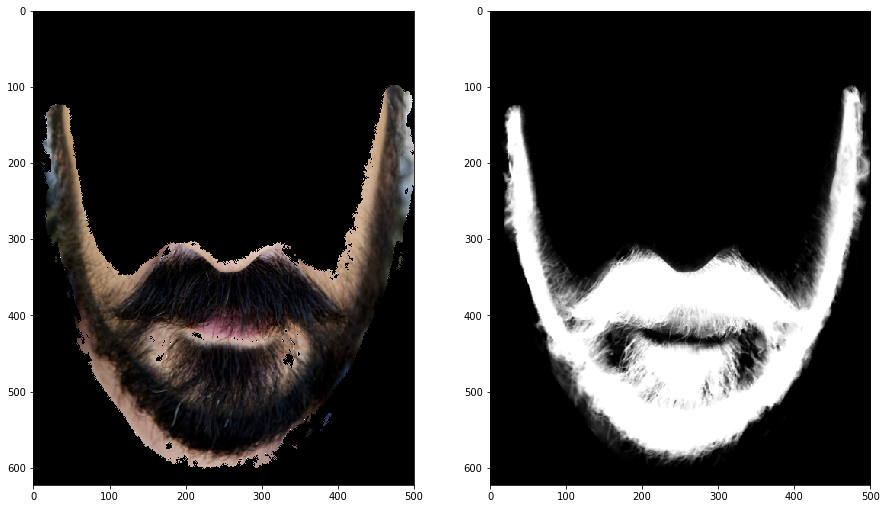

In [7]:
b, g, r, a = cv2.split(imgWithMask)
beard = cv2.merge((b,g,r))
beard = np.float32(beard)/255

# Take the 4th channel and create the alpha mask used for blending
beardAlphaMask = cv2.merge((a,a,a))
beardAlphaMask = np.float32(beardAlphaMask)
plt.figure(figsize=[15,10])
plt.subplot(121);plt.imshow(beard[...,::-1])
plt.subplot(122);plt.imshow(np.uint8(beardAlphaMask[...,::-1]))

In [8]:
sizeImg1 = beard.shape    
rect = (0, 0, sizeImg1[1], sizeImg1[0])
dt = fbc.calculateDelaunayTriangles(rect, featurePoints1)

True

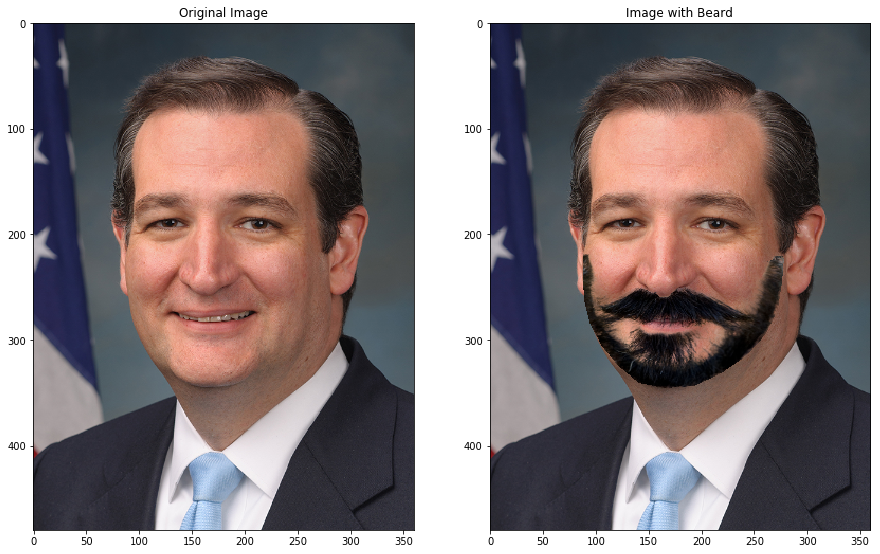

In [54]:
FACE_DOWNSAMPLE_RATIO = 1
RESIZE_HEIGHT = 480
height, width = img1.shape[:2]
IMAGE_RESIZE = np.float32(height)/RESIZE_HEIGHT
targetImage = cv2.resize(img1,None,
                 fx=1.0/IMAGE_RESIZE,
                 fy=1.0/IMAGE_RESIZE,
                 interpolation = cv2.INTER_LINEAR)

points2 = fbc.getLandmarks(faceDetector, landmarkDetector, cv2.cvtColor(targetImage, cv2.COLOR_BGR2RGB), FACE_DOWNSAMPLE_RATIO)
featurePoints2 = []
for p in pts_of_interest:
    pt = points2[p]
    pt = fbc.constrainPoint(pt, width, height)
    featurePoints2.append(pt)

targetImage = np.float32(targetImage)/255

beardWarped = np.zeros(targetImage.shape)
beardAlphaWarped = np.zeros(targetImage.shape)

# Apply affine transformation to Delaunay triangles
for i in range(0, len(dt)):
    t1 = []
    t2 = []

    #get points for img1, img2 corresponding to the triangles
    for j in range(0, 3):
        t1.append(featurePoints1[dt[i][j]])
        t2.append(featurePoints2[dt[i][j]])

    fbc.warpTriangle(beard, beardWarped, t1, t2)
    fbc.warpTriangle(beard_mask, beardAlphaWarped, t1, t2)

beardWarpedMask = beardAlphaWarped/255
temp1 = np.multiply(targetImage, 1.0 - beardWarpedMask)
temp2 = np.multiply(beardWarped, beardWarpedMask)

out = temp1 + temp2;
plt.figure(figsize=[15,10])
plt.subplot(121);plt.imshow(targetImage[...,::-1]);plt.title("Original Image")
plt.subplot(122);plt.imshow(out[...,::-1]);plt.title("Image with Beard")
cv2.imwrite("beardify.jpg", np.uint8(255*out))